# Iceberg for Spark: Performance Comparison Tutorial

In this notebook, we will compare performance between classic Spark tables and Iceberg tables.

First, install Docker and Docker Compose. Next, create a docker-compose.yaml file with the contents of https://iceberg.apache.org/spark-quickstart/. Use ̀docker-compose up to install all necessary files.

You can also launch a notebook server by running docker exec -it spark-iceberg notebook. The notebook server will be available at http://localhost:8888


In [1]:
import io
import random
from  pyspark.sql.types import StructType,StructField,IntegerType,FloatType 
import time
import statistics as stats
import matplotlib.pyplot as plt

## Program settings

In [2]:
# Number of run for stat on query, must be > 1
NUM_MES = 8  #10
# Number of Size Test
NUM_RUN = 8 # 8  
# Number of computed rows
BASE_SIZE = 70000 
# Increase at each step
SAMPLING_RATIO = 1.0
# 1 hour computation for thoses values

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Jupyter").getOrCreate()

spark

23/10/20 13:17:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
%%sql
CREATE DATABASE IF NOT EXISTS db

++
||
++
++

## Generation of the first dataset

We will start by generating a synthetic dataset with the following columns:
* A Gaussian value
* Four categorical uniform variables with increasing cardinalities (i.e. the number of distinct possible values increases).

The dataset generation function is as follows:

In [5]:
res_by_queries = {}

output_buffer = io.StringIO()
original_stdout = sys.stdout

try:
       data = [( random.normalvariate(50,10),random.randint(0, 4),random.randint(0,50),random.randint(0,200),random.randint(0,400)) for _ in range(BASE_SIZE)]
       schema = StructType([StructField("Value", FloatType(), False),
                            StructField("low_card", IntegerType(), False),
                            StructField("medium_card", IntegerType(), False),
                            StructField("high_card", IntegerType(), False), 
                            StructField("max_card", IntegerType(), False)])
    
       base = spark.createDataFrame(data, schema)

except Exception as e:
        print("Une erreur s'est produite lors de la génération du DataFrame :", str(e))

#base.write.mode("overwrite").parquet("ds.parquet",compression="none") # or  "uncompressed"

current_size = BASE_SIZE
base_size = current_size * (4 + 3 *4 +4)
df_size_bytes = base_size

We estimate the dataset size to be around 16 bytes per row.

To quickly change the size of the dataset, we will add part of its current contents in each iteration using base = base.union(base.sample(SAMPLING_RATIO)). This approach allows us to observe how performance scales with the size of the dataset.

## Requests

The requests that we will use to carry out our tests:

In [6]:
queries = [
    ("Q1", "SELECT *", " WHERE low_card = 2 "),
    ("Q2", "SELECT * ", "WHERE medium_card = 25 "),
    ("Q3", "SELECT * ", "WHERE high_card = 100 "),
    ("Q4", "SELECT * ", "WHERE max_card = 200 "),
    ("Q5", "SELECT low_card, AVG(value)", "GROUP BY low_card "),
    ("Q6", "SELECT medium_card, AVG(value)", " GROUP BY medium_card "),
    ("Q7", "SELECT high_card, AVG(value) ", "GROUP BY high_card "),
    ("Q8", "SELECT max_card, AVG(value) ", "GROUP BY max_card ")
]

In [7]:
print(base.describe().show())
print("Size in MiB", df_size_bytes/1024./1024.)
df = base.alias("copy")

23/10/20 13:17:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|             Value|          low_card|       medium_card|        high_card|          max_card|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             70000|             70000|             70000|            70000|             70000|
|   mean|50.043049781942365|2.0073142857142856|24.979814285714287|99.77834285714286|199.54877142857143|
| stddev| 9.984969308463594|1.4189244842103172|14.715371467445255|57.97236774818964|115.93397259895981|
|    min|         2.1110773|                 0|                 0|                0|                 0|
|    max|         92.028206|                 4|                50|              200|               400|
+-------+------------------+------------------+------------------+-----------------+------------------+

None
Size in MiB 1.33514404296875


In [8]:
%%time
for i in range(NUM_RUN):

    print (f"run {i+1}/{NUM_RUN}")
    
    df = df.union(df.sample(SAMPLING_RATIO))
    df_size_bytes = df_size_bytes + SAMPLING_RATIO * df_size_bytes
    
    df.createOrReplaceTempView("df")
    
    spark.sql("DROP TABLE  IF EXISTS db.table PURGE")
    df.writeTo("db.table").using("iceberg").create()

    # Blank request, to force the different loadings into memory
    spark.sql("SELECT * FROM db.table WHERE low_card >1")
    
    for q_name,q_start,q_end in queries:
        print(f"Running new test :",q_name)
        show_duration_iceberg = []
        show_duration_base = []

        for _ in range(NUM_MES):
            result = spark.sql(q_start + " FROM db.table "+q_end)
            start_time = time.time()
            result.show()
            end_time = time.time()
            show_duration_iceberg.append(end_time - start_time)
            sys.stdout = output_buffer
        sys.stdout = original_stdout
        
        for _ in range(NUM_MES):
            result = spark.sql(q_start + " FROM df "+q_end)
            start_time = time.time()
            result.show()
            end_time = time.time()
            show_duration_base.append(end_time - start_time)
            sys.stdout = output_buffer
 
        sys.stdout = original_stdout
        computed_ratio = [  show_duration_base[i] / show_duration_iceberg[i] for i in range(len(show_duration_base))]
        
        res = f"{float(df_size_bytes)};{stats.mean(show_duration_iceberg)};{stats.stdev(show_duration_iceberg)};{stats.mean(show_duration_base)};{stats.stdev(show_duration_base)};{stats.mean(computed_ratio)}; { stats.stdev(computed_ratio)};"
        print(res)
        old_dic = res_by_queries.get(q_name, {})
        old_dic[df_size_bytes] = res
        res_by_queries[q_name] = old_dic

run 1/8


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



11200000.0;0.40505629777908325;0.0663644550718728;0.7118437588214874;0.0716964970299551;1.7803732172196682; 0.19923953227641375;
Running new test : Q6
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows

+-----------+------------------

11200000.0;0.3624323904514313;0.02558303166768466;0.7195473313331604;0.029502185686867844;1.992556768333752; 0.143407269371244;
Running new test : Q7
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



11200000.0;0.3637503385543823;0.034222684702261565;0.920220673084259;0.04401770267559374;2.543426137037802; 0.1953895730530841;
Running new test : Q8
+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



11200000.0;0.36154410243034363;0.036932459608889086;1.1341398358345032;0.07954639422963498;3.1691523699495026; 0.41921796474248774;
run 4/8


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



22400000.0;0.33040955662727356;0.049614299843662855;1.2590134143829346;0.10472196589163088;3.853295596875006; 0.4094131147890929;
Running new test : Q6
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



22400000.0;0.3315163552761078;0.03294893510231805;1.4773853719234467;0.1193319811467306;4.48396698984435; 0.4744076463098028;
Running new test : Q7
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



22400000.0;0.3442237377166748;0.05088201719109935;1.9510518610477448;0.0975684657286509;5.785300133699483; 0.9527452107906202;
Running new test : Q8
+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



22400000.0;0.34266236424446106;0.01971526449789158;2.121152251958847;0.06484926722552756;6.206331820044416; 0.3719957004926471;
run 5/8


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



44800000.0;0.4237872362136841;0.03682618970658204;2.55336731672287;0.23795421439012995;6.0660272843143215; 0.7766785623259402;
Running new test : Q6
+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



44800000.0;0.46573585271835327;0.05819924674698444;2.8645860850811005;0.12291517933002251;6.235133173463864; 0.8172694794310478;
Running new test : Q7
+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



44800000.0;0.45025667548179626;0.031586592160909956;3.700719565153122;0.14408356675967765;8.258469183344857; 0.7071740754750622;
Running new test : Q8
+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



44800000.0;0.5405424237251282;0.0849715395323232;4.128344506025314;0.18761748733272088;7.811515118126689; 1.310619707059091;
run 6/8


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



89600000.0;0.7898072302341461;0.06305813723992819;6.222363114356995;0.19808483813753894;7.916476603214047; 0.5945472036936247;
Running new test : Q6


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



89600000.0;0.8620505630970001;0.04951364867767195;7.016298174858093;0.36616082440448006;8.152051267099143; 0.4476337734067877;
Running new test : Q7


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



89600000.0;0.9205331802368164;0.08405480351546056;8.780448734760284;0.19526971244062233;9.598642184054853; 0.7800840886274022;
Running new test : Q8


+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



89600000.0;1.019449770450592;0.0879680854725864;9.370148718357086;0.31933892126957036;9.23872438906897; 0.7003037601677913;
run 7/8


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



179200000.0;1.481650948524475;0.10506561325514327;14.631300747394562;0.24928850898345847;9.918823610831817; 0.7275057939536028;
Running new test : Q6


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



179200000.0;1.6722407639026642;0.06197309432334195;15.691386580467224;0.46012443731675784;9.397029182043159; 0.49618059428593486;
Running new test : Q7


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



179200000.0;1.6956158578395844;0.08853141286589031;19.025206357240677;0.30404498156685755;11.246330999618568; 0.6038991775436516;
Running new test : Q8


+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



179200000.0;1.8205622732639313;0.14746917531765227;22.569111078977585;0.49555027982558875;12.468961997611371; 1.067312603955897;
run 8/8


Running new test : Q1
+---------+--------+-----------+---------+--------+
|    Value|low_card|medium_card|high_card|max_card|
+---------+--------+-----------+---------+--------+
| 52.70312|       2|          8|      160|     228|
| 39.43254|       2|         32|      178|     279|
|54.230255|       2|         47|      103|     258|
|27.352919|       2|         11|      162|     270|
|54.558735|       2|         10|      108|     325|
|48.877037|       2|          8|       35|     126|
|33.545853|       2|         11|       33|     118|
|64.545204|       2|          7|       43|     151|
|43.354942|       2|         43|       90|     338|
|43.788265|       2|         24|       45|     135|
|56.494366|       2|         16|       89|      98|
| 60.51466|       2|          5|      131|     254|
|48.680332|       2|         23|      168|     105|
| 47.67017|       2|          8|       93|     392|
| 60.13637|       2|         40|       56|     181|
|51.722057|       2|          4|       44|

+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



23/10/20 13:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


+--------+-----------------+
|low_card|       avg(value)|
+--------+-----------------+
|       1|49.91769074035401|
|       3|50.06885857085115|
|       4|50.08339776124607|
|       2|50.16422013283734|
|       0| 49.9802456024287|
+--------+-----------------+



23/10/20 13:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:45:11 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


358400000.0;3.0939415991306305;0.25235556560641176;35.61648106575012;0.5179774535137588;11.571683028690186; 0.849942453814202;
Running new test : Q6


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



23/10/20 13:46:13 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


+-----------+------------------+
|medium_card|        avg(value)|
+-----------+------------------+
|         31|50.240867592936496|
|         34|50.078787741966025|
|         28| 50.09201009541492|
|         27|49.821319640031334|
|         26|49.996629231530044|
|         44| 50.33976191486606|
|         12| 50.19650262624392|
|         22| 50.68914606007535|
|         47| 49.64440252895439|
|          1| 50.50770172706017|
|         13| 50.02283587428026|
|         16|  50.3695201818931|
|          6| 49.82136674360795|
|          3| 50.37658156234853|
|         40|50.448348242127906|
|         20| 50.18847904539945|
|         48|49.911127124212484|
|          5| 50.10172505906244|
|         19| 50.01736227201845|
|         41| 49.91780913832747|
+-----------+------------------+
only showing top 20 rows



23/10/20 13:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:48:14 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:49:35 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


358400000.0;3.2960831820964813;0.09831455751467613;43.73125097155571;5.953192973024748;13.29036481470585; 1.9592304804510907;
Running new test : Q7


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



23/10/20 13:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


+---------+------------------+
|high_card|        avg(value)|
+---------+------------------+
|      148| 50.47087180685009|
|       31|50.329321562354245|
|      137| 51.75680216913638|
|       85| 48.66326543324029|
|       65| 50.22750402987003|
|       53| 51.55655873340109|
|      133| 49.84757170045232|
|       78| 50.19682641824087|
|      108| 49.58781712082611|
|      155| 50.38346390866329|
|       34| 50.63694594499004|
|      193|50.165484341708094|
|      115| 49.83611075537545|
|      101| 50.18933895088377|
|      126| 49.35580818262478|
|       81| 50.27152225505506|
|       28| 49.90958152977196|
|      183| 50.33318266909347|
|       76|49.544668824173684|
|       26|49.559131350628164|
+---------+------------------+
only showing top 20 rows



23/10/20 13:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 13:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


358400000.0;4.415441632270813;0.5953066628667979;50.61650907993317;2.1975126887497316;11.614502017078324; 1.3644232264242526;
Running new test : Q8


+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



23/10/20 13:59:57 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


+--------+------------------+
|max_card|        avg(value)|
+--------+------------------+
|     148|50.159056820446935|
|     392| 49.87039775303432|
|     243|  50.2848171796955|
|      31| 49.96186186546503|
|     137|51.023059766432816|
|      85|50.586086736249094|
|     251|48.854267211731326|
|      65| 48.34064567729991|
|      53|49.747673265226595|
|     255|49.985135251825504|
|     133|50.984076025957116|
|     296|   48.887526410918|
|      78|  49.9444771816856|
|     322| 50.61855616891311|
|     362| 52.04982815366803|
|     321| 50.20909890150413|
|     375| 49.80950400942848|
|     108|49.476850998963364|
|     155| 50.85858447811147|
|      34| 50.50787984227841|
+--------+------------------+
only showing top 20 rows



23/10/20 14:00:53 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:01:50 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:02:48 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB
23/10/20 14:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


358400000.0;4.047143757343292;0.1569080288126283;56.83487945795059;0.8214729136368556;14.062666033110808; 0.6054722147875967;
CPU times: user 18.5 s, sys: 5.88 s, total: 24.3 s
Wall time: 50min 5s


We collect the data to be able to visualize them.

In [9]:
size = [key for key in res_by_queries['Q1'].keys()]
size_MiB =  [v / 1024 / 1024. for v in size]

In [10]:
queries = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

Q_dict = {}
STDQ_dict = {}

for query in queries:
    Q_dict[query] = []
    STDQ_dict[query] = []

    for k, v in res_by_queries[query].items():
        tab = v.split(";")
        Q_dict[query].append(float(tab[-3]))
        STDQ_dict[query].append(float(tab[-2]))

## Visualization
### Overview

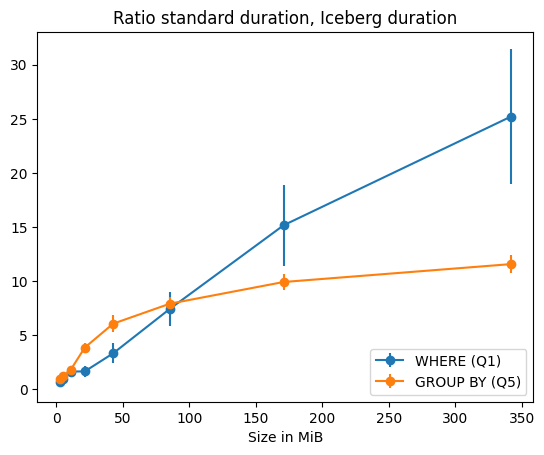

In [11]:
fig = plt.figure()
plt.errorbar(size_MiB, Q_dict['Q1'], yerr=STDQ_dict['Q1'], label='WHERE (Q1)',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q2'], yerr=STDQ_dict['Q2'], label='Q2',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q3'], yerr=STDQ_dict['Q3'], label='Q3',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q4'], yerr=STDQ_dict['Q4'], label='Q4',  fmt='-o')
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Size in MiB")
plt.errorbar(size_MiB, Q_dict['Q5'], yerr=STDQ_dict['Q5'], label='GROUP BY (Q5)',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q6'], yerr=STDQ_dict['Q6'], label='Q6',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q7'], yerr=STDQ_dict['Q7'], label='Q7',  fmt='-o')
#plt.errorbar(size_GiB, Q_dict['Q8'], yerr=STDQ_dict['Q8'], label='Q8',  fmt='-o')
plt.title('Ratio standard duration, Iceberg duration')
#plt.xlim(left=0.5) 
#plt.xlim(right=200)  
#plt.ylim(top=10)  
plt.legend(loc='lower right')

For very small tables the gain is less than or close to one. Gain is better with GROUP BY.
With a 80 MiB dataset the WHERE and GROUP BY are 6.5 faster with Iceberg.
The gain increases as the table grows. This growth is slow for the `GROUP BY`, stronger for the `WHERE`.



### WHERE queries

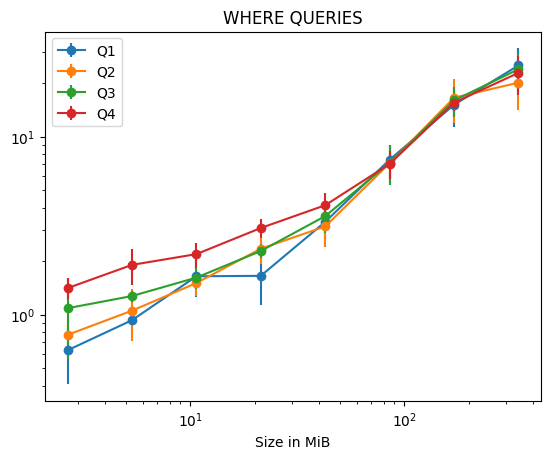

In [12]:
fig = plt.figure()
plt.errorbar(size_MiB, Q_dict['Q1'], yerr=STDQ_dict['Q1'], label='Q1',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q2'], yerr=STDQ_dict['Q2'], label='Q2',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q3'], yerr=STDQ_dict['Q3'], label='Q3',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q4'], yerr=STDQ_dict['Q4'], label='Q4',  fmt='-o')
plt.xscale("log") 
plt.yscale("log") 
plt.title('WHERE QUERIES')
plt.xlabel("Size in MiB")
plt.legend()

It is a progression in power law depending on the size of the data set. The curves intersect many times, the impact of the cardinalities is not visible.

### GROUP BY queries

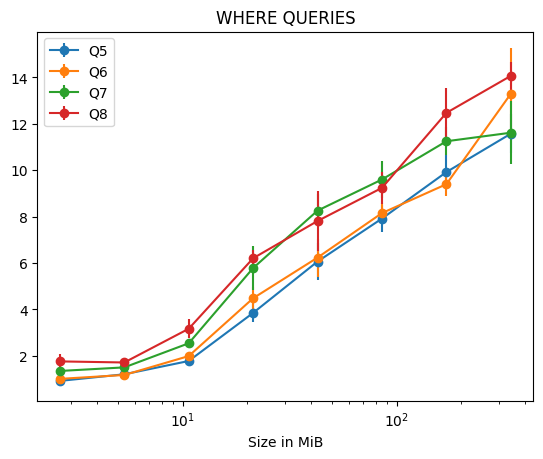

In [13]:
fig = plt.figure()
plt.errorbar(size_MiB, Q_dict['Q5'], yerr=STDQ_dict['Q5'], label='Q5',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q6'], yerr=STDQ_dict['Q6'], label='Q6',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q7'], yerr=STDQ_dict['Q7'], label='Q7',  fmt='-o')
plt.errorbar(size_MiB, Q_dict['Q8'], yerr=STDQ_dict['Q8'], label='Q8',  fmt='-o')
plt.xscale("log") 
#plt.yscale("log")
plt.title('WHERE QUERIES')
plt.xlabel("Size in MiB")
plt.legend()

`GROUP BY` follow a log law depending on the size of the dataset. The curves cross very rarely, remaining within the measurement uncertainty. The curves are ordered according to the cardinality of the variable. This is the mark of the bloom filter which is all the more efficient as the cardinality is large.

In [14]:
 spark.sql("DROP TABLE  IF EXISTS db.table PURGE")

DataFrame[]

## Conclusion

The results show that Iceberg is a format suitable for big data applications. For small tables, Iceberg brings little benefit, or even degrades performance, but these calculations are already fast. Iceberg brings an extremely interesting gain for larger datasets. WHERE type queries benefit from data pruning, while GROUP BY queries benefit from the Bloom filter, becoming more and more efficient with high cardinality. Due to the behavior of the curves, for large tables, pruning will always perform best, because the logarithm grows more slowly than any power.
In any case, beyond 350 MiB, the gain will always be greater than 10 (but you will have to modify the queries to convince yourself of this).


The tutorial aims to help you understand Iceberg's performance benefits compared to Spark default tables. Note that running memory-intensive tasks on small clusters can lead to memory saturation, so it's essential to monitor memory usage and avoid computationally intensive operations. Spark recommends keeping tasks under 1 GiB in size to ensure smooth execution.

Feel free to modify parameters and explore different scenarios to better understand how Iceberg can enhance your large-scale data processing pipelines. For example you can perform multiple experiments:
* adjust settings,
* modify queries,
* measure the impact of the number of snapshots when creating the Iceberg table.

In production, it is essential to have a true cluster, that is, a configuration with several processing nodes. In addition, it is imperative to fine-tune Spark and, more generally, to optimize your entire cluster to get the most out of the improvements provided by Iceberg.

Mastering your infrastructure therefore remains essential to guarantee optimal performance and make the adoption of Iceberg fully profitable in your data processing environments.